In [1]:
from pathlib import Path
from matplotlib.patches import Circle, Rectangle
import json
import zarr
import copick
import copick_utils
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from monai.transforms import SpatialCrop
from monai.transforms import crop_func
import matplotlib.pyplot as plt
import numpy as np
from itertools import zip_longest
import seaborn as sns

sns.set_palette("colorblind")

In [2]:
data_root = Path.cwd().parent / "data"

train_path = data_root / "train"
test_path = data_root / "test"


all_runs = ["TS_5_4", "TS_6_4", "TS_6_6", "TS_69_2", "TS_73_6", "TS_86_3", "TS_99_9"]

voxel_spacing = 10

particle_radius = {
    "apo-ferritin": 60,
    "beta-amylase": 65,
    "beta-galactosidase": 90,
    "ribosome": 150,
    "thyroglobulin": 130,
    "virus-like-particle": 135,
    "membrane": None,
    "background": None,
}

class_mapping = {
    "apo-ferritin": 0,
    "beta-amylase": 1,
    "beta-galactosidase": 2,
    "ribosome": 3,
    "thyroglobulin": 4,
    "virus-like-particle": 5,
}

In [3]:
run = "TS_5_4"


def get_zarr(run, train_path=train_path):

    zarr_path = (
        train_path
        / "static"
        / "ExperimentRuns"
        / run
        / "VoxelSpacing10.000"
        / "denoised.zarr"
    )
    return zarr.open(zarr_path)


def get_transform(z, resolution: int):
    return np.array(
        z.attrs["multiscales"][0]["datasets"][resolution]["coordinateTransformations"][
            0
        ]["scale"]
    )


z = get_zarr(run)

z_transform = get_transform(z, 0)
print(z_transform)

[10.0124442  10.0124442  10.01244454]


,name,run,x,y,z,radius,z_coord,y_coord,x_coord
0,beta-amylase,TS_5_4,5417.091,1120.574,567.527,65,57,112,541
1,beta-amylase,TS_5_4,4340.000,1220.000,365.000,65,36,122,433
2,beta-amylase,TS_5_4,4908.973,1745.891,279.668,65,28,174,490
3,beta-amylase,TS_5_4,5153.200,4595.200,420.800,65,42,459,515
4,beta-amylase,TS_5_4,1500.000,4212.222,1016.667,65,102,421,150


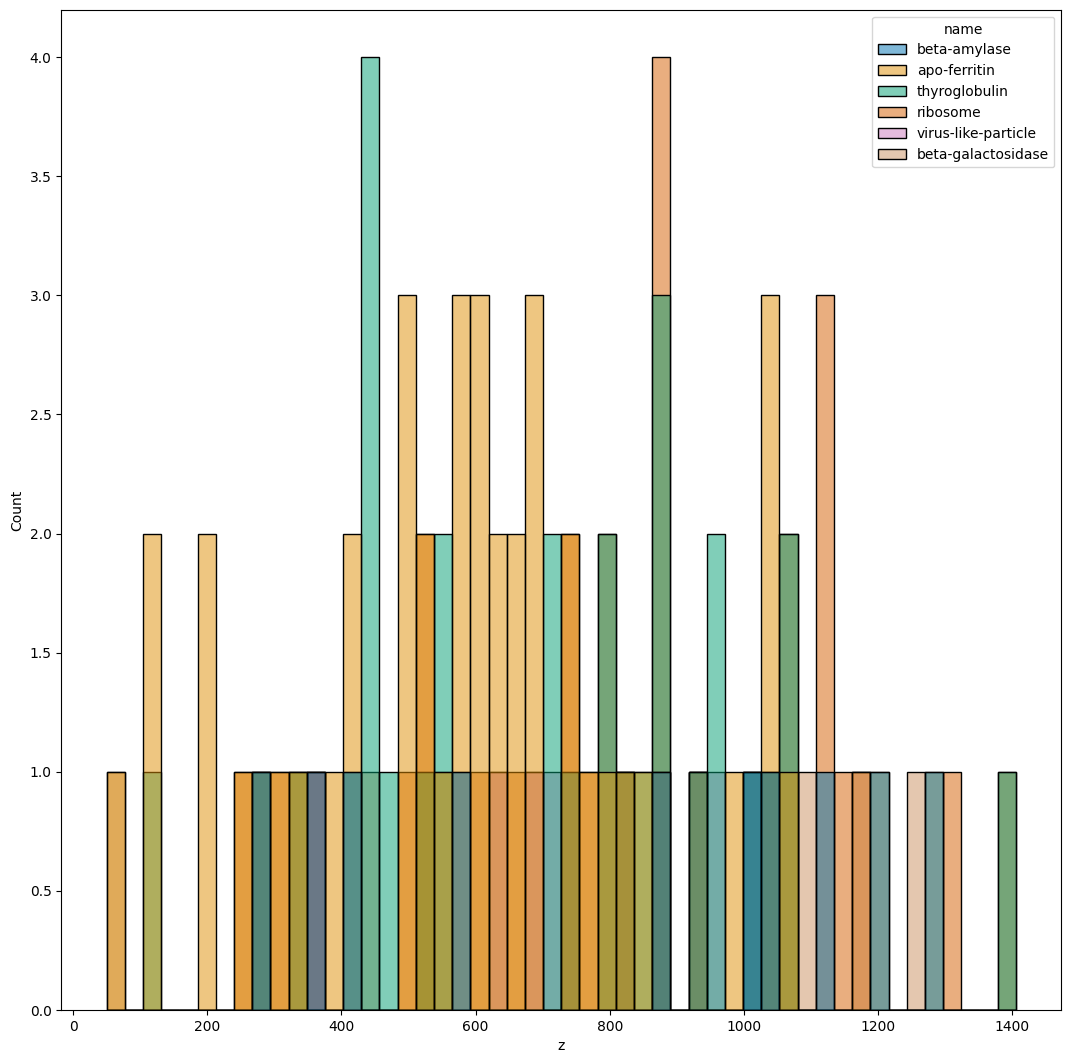

In [4]:
def get_picks(run, transform):
    picks_path = train_path / "overlay" / "ExperimentRuns" / run / "Picks"

    rows = []
    for file in picks_path.iterdir():
        with file.open() as io:
            data = json.load(io)

        name = data["pickable_object_name"]
        run_name = data["run_name"]

        objects = [
            {
                "name": name,
                "run": run_name,
                **x["location"],
                "radius": particle_radius[name],
            }
            for x in data["points"]
        ]

        rows.extend(objects)

    picks = pd.DataFrame(rows)

    # Compute center coordinates for the picks in Volumetric coordinates
    picks[["z_coord", "y_coord", "x_coord"]] = (
        (picks[["z", "y", "x"]] / transform).round().astype(int)
    )

    return picks


picks_df = get_picks(run, get_transform(z, 0))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0, 0, 1, 1))
sns.histplot(data=picks_df, x="z", hue="name", bins=50, ax=ax)
picks_df.head()

TypeError: get_picks() missing 1 required positional argument: 'transform'

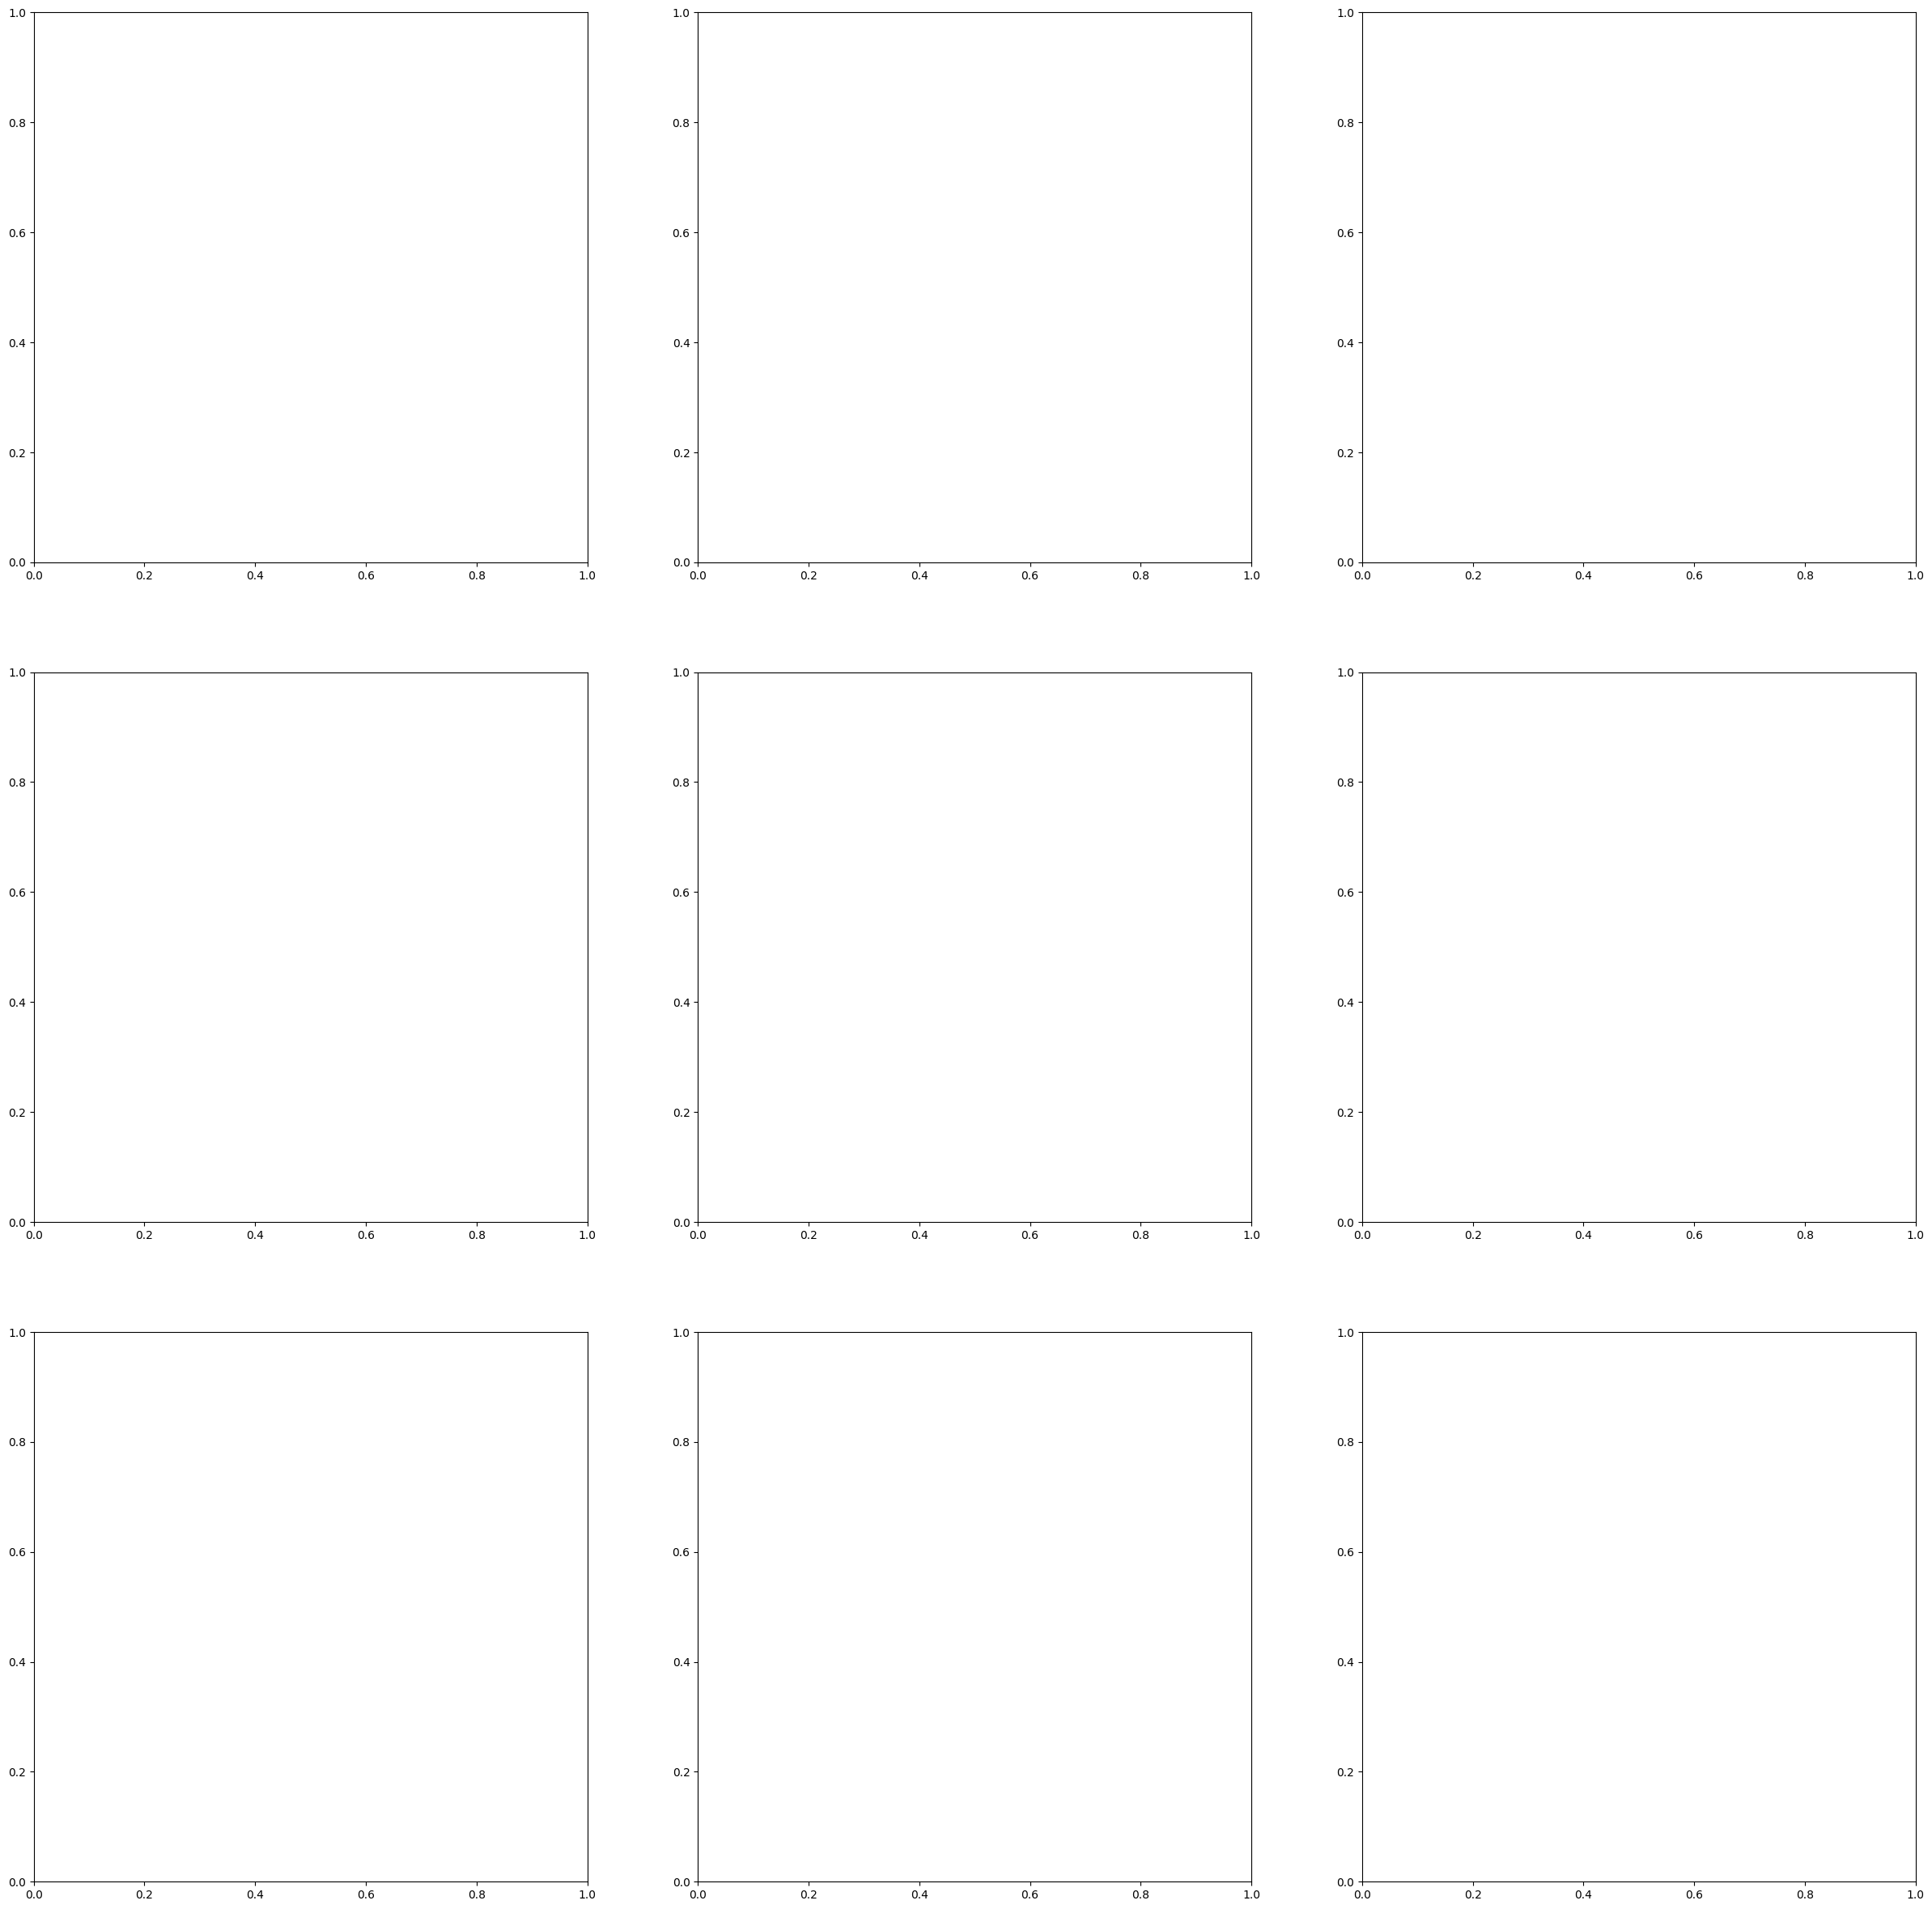

In [5]:
color_mapping = {
    "apo-ferritin": "red",
    "beta-amylase": "yellow",
    "beta-galactosidase": "blue",
    "ribosome": "green",
    "thyroglobulin": "purple",
    "virus-like-particle": "orange",
}
z_slice = 100

resolution = 0


def plot_z_slice(z_slice, run, resolution, ax=None):

    static = get_zarr(run)
    picks = get_picks(run)
    transform = get_transform(static, resolution)

    z = z_slice * transform[0]

    relevant_picks = picks[
        picks.apply(
            lambda x: np.abs(x["z"] - z) < x["radius"],
            axis=1,
        )
    ].copy()

    relevant_picks[["coord_x", "coord_y", "coord_z"]] = (
        (relevant_picks[["x", "y", "z"]] / transform).round().fillna(0).astype(int)
    )

    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_axes([0, 0, 1, 1])

    ax.imshow(static[resolution][z_slice, :, :], cmap="gray")

    ax.set_title(f"{run}: z = {z}")

    for idx, row in relevant_picks.iterrows():
        circle = Circle(
            (row["coord_x"], row["coord_y"]),
            radius=row["radius"] / transform[0],
            edgecolor=color_mapping[row["name"]],
            facecolor="none",
        )
        ax.add_patch(circle)


fig, axes = plt.subplots(3, 3, figsize=(30, 30))

# z_slices = [10, 20, 30, 40, 50, 60, 70, 80, 90]
z_slices = range(10, 30, 2)

for z_slice, ax in zip_longest(z_slices, axes.flatten()):
    if z_slice is None:
        ax.axis("off")
    elif ax is None:
        break
    else:
        plot_z_slice(z_slice, run, resolution, ax=ax)

NameError: name 'area' is not defined

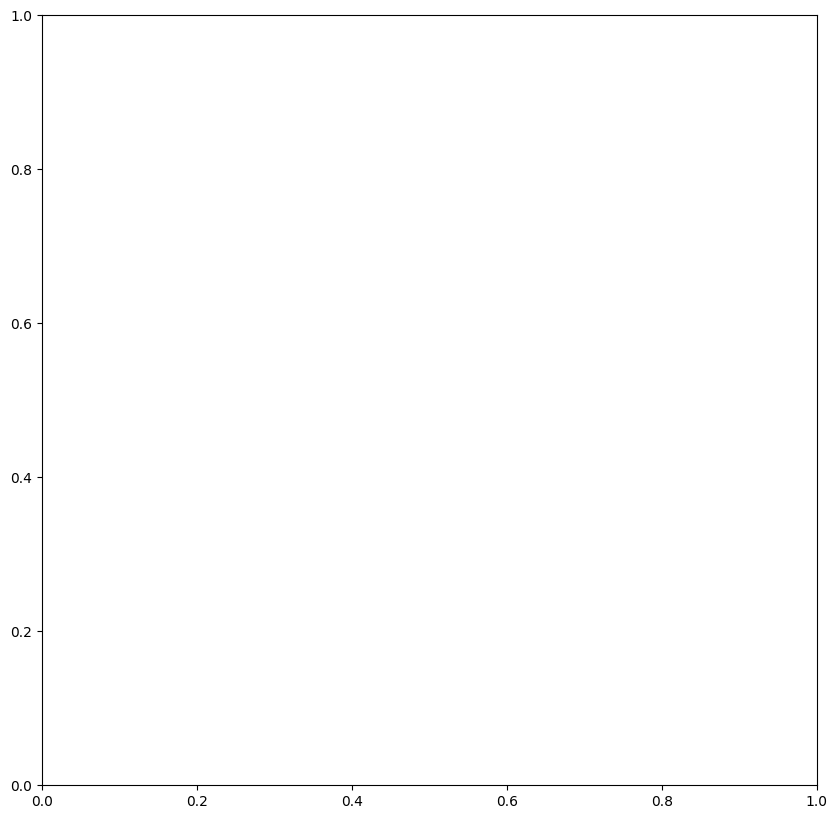

In [6]:
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 10))

x_slice = 70
y_slice = 35
z_slice = 12

ax1.imshow(area[z_slice, :, :], cmap="gray")
ax1.set_title("Top")
ax1.plot([0, area.shape[2]], [y_slice, y_slice])
ax1.plot([x_slice, x_slice], [0, area.shape[1]])


fig2, ax2 = plt.subplots(1, 1, figsize=(10, 10))

ax2.imshow(area[:, y_slice, :], cmap="gray")
ax2.set_title("Front")
ax2.plot([0, area.shape[2]], [y_slice, y_slice])
ax2.plot([x_slice, x_slice], [0, area.shape[1]])

fig3, ax3 = plt.subplots(1, 1, figsize=(10, 10))

ax3.imshow(area[:, :, x_slice], cmap="gray")
ax3.set_title("Side")

## Model

In [7]:
import lightning as L
from monai.apps.detection.networks.retinanet_detector import (
    retinanet_resnet50_fpn_detector,
)
import monai

In [ ]:
import torch
from monai.transforms.croppad import functional


def compute_box(row, slices):

    # For now stupid version that is not exact and doesn't take different transform amplitudes in different axis into account
    resol = 10

    x_offset = slices[2].start
    y_offset = slices[1].start
    z_offset = slices[0].start

    x_min = np.round(row.x_coord - row.radius / resol - x_offset).astype(int)
    x_max = np.round(row.x_coord + row.radius / resol - x_offset).astype(int)
    y_min = np.round(row.y_coord - row.radius / resol - y_offset).astype(int)
    y_max = np.round(row.y_coord + row.radius / resol - y_offset).astype(int)
    z_min = np.round(row.z_coord - row.radius / resol - z_offset).astype(int)
    z_max = np.round(row.z_coord + row.radius / resol - z_offset).astype(int)

    return [x_min, y_min, z_min, x_max, y_max, z_max]


class CryoETDataset(Dataset):
    def __init__(self, runs: list, sample_size: int, class_mapping: dict[str, int]):
        self._zarrs = [get_zarr(run) for run in runs]
        self._picks = [
            get_picks(run, get_transform(z, 0)) for run, z in zip(runs, self._zarrs)
        ]

        self._tot_length = sum([x.shape[0] for x in self._picks])

        self._compute_slices = SpatialCrop.compute_slices
        self._crop_func = crop_func

        self._sample_size = sample_size
        self._mapping = class_mapping

    def __len__(self):
        return self._tot_length

    def __getitem__(self, idx: int):

        # Get the run in which this particle is located
        in_run_idx = idx
        run_idx = 0
        for r in self._picks:
            if in_run_idx < r.shape[0]:
                break
            else:
                run_idx += 1
                in_run_idx -= r.shape[0]

        # Select the particle, crop the volumetric data around this particle
        particle = self._picks[run_idx].iloc[in_run_idx, :]

        slice_coords = self._compute_slices(
            roi_center=particle[["z_coord", "y_coord", "x_coord"]].to_list(),
            roi_size=(self._sample_size, self._sample_size, self._sample_size),
        )

        subvolume = torch.Tensor(self._zarrs[run_idx][0][*slice_coords]).unsqueeze(0)
        # subvolume_tensor = torch.Tensor(subvolume).unsqueeze(0)

        # If a particle was selected that is on the edge of the volume, the result needs to be padded
        if not all([x == self._sample_size for x in subvolume.shape[1:]]):
            padding = [(0, 0)]
            for idx, s in enumerate(slice_coords):
                lower_padding = np.abs(s.start) if s.start < 0 else 0
                upper_padding = s.stop - self._zarrs[run_idx][0].shape[idx]
                upper_padding = upper_padding if upper_padding > 0 else 0
                padding.append((lower_padding, upper_padding))

            # assuming channel isn't padding unsqueeze to fix
            subvolume = functional.pad_nd(subvolume, to_pad=padding)

        # Find particles that intersect this subvolumes
        picks_df = self._picks[run_idx]
        subvolume_particles_df = picks_df[
            (
                (picks_df.z_coord >= slice_coords[0].start)
                & (picks_df.z_coord < slice_coords[0].stop)
            )
            & (
                (picks_df.y_coord >= slice_coords[1].start)
                & (picks_df.y_coord < slice_coords[1].stop)
            )
            & (
                (picks_df.x_coord >= slice_coords[2].start)
                & (picks_df.x_coord < slice_coords[2].stop)
            )
        ]

        boxes = []
        labels = []
        for _, row in subvolume_particles_df.iterrows():
            box = compute_box(row, slice_coords)

            box_tensor = torch.Tensor(box)

            label = self._mapping[row["name"]]

            boxes.append(box_tensor)
            labels.append(label)

        return {
            "targets": {
                "boxes": torch.stack(boxes),
                "labels": torch.Tensor(labels).long(),
            },
            "image": subvolume,
            "slices": slice_coords,
            "zarr": self._zarrs[run_idx],
        }


def collate_fn(batch):
    images, targets = zip(*[(x["image"], x["targets"]) for x in batch])
    images = torch.stack(images)

    return {"image": images, "targets": targets}


sample_size = 64
train_dataset = CryoETDataset(
    all_runs[0:4], sample_size=sample_size, class_mapping=class_mapping
)
val_dataset = CryoETDataset(
    all_runs[4:], sample_size=sample_size, class_mapping=class_mapping
)

train_loader = DataLoader(train_dataset, batch_size=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn)

In [182]:
train_dataset[176 * 2 + 1]["zarr"][0].shape

Upper:	0
lOwer:	0
Upper:	0
lOwer:	0
Upper:	0
lOwer:	0


(184, 630, 630)

In [177]:
train_dataset[176 * 2 + 1]["slices"]

Upper:	0
lOwer:	0
Upper:	0
lOwer:	0
Upper:	0
lOwer:	0


(slice(123, 187, None), slice(231, 295, None), slice(43, 107, None))

In [180]:
107 - 43

64

In [203]:
train_dataset[176 * 2 + 1]["image"].shape

[(0, 0), (0, 3), (0, 0), (0, 0)]
torch.Size([1, 61, 64, 64])
torch.Size([1, 64, 64, 64])


NameError: name 'subvolume_tensor' is not defined

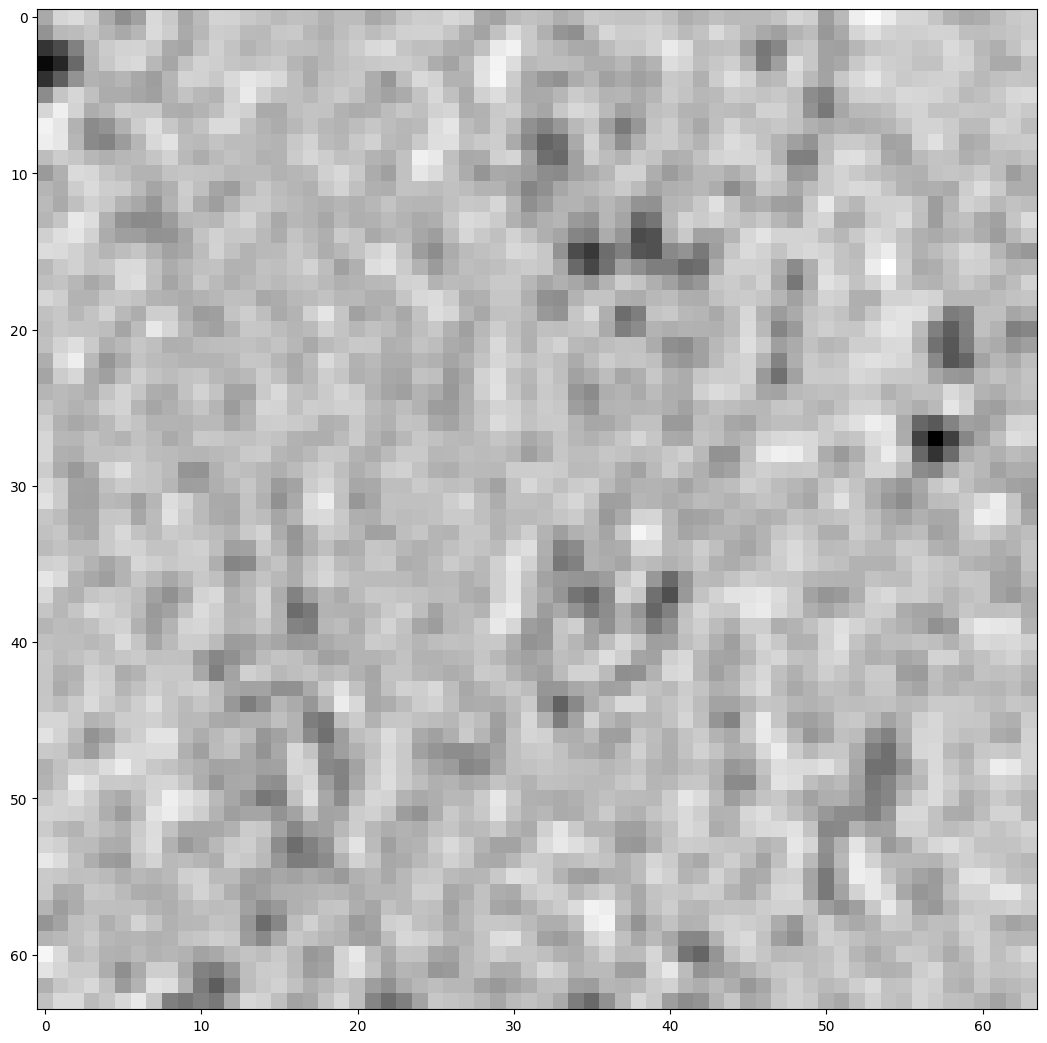

In [116]:
sample_index = 0
sample = train_dataset[sample_index]

image = sample["image"]
boxes = sample["targets"]["boxes"]
labels = sample["targets"]["labels"]


fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0, 0, 1, 1])
z_level = 60
ax.imshow(image[0, z_level, :, :], cmap="gray")

for box in boxes:
    # Check if slice is in z span
    if not (z_level > box[2] and z_level < box[5]):
        continue
    rec = Rectangle(
        (box[0], box[1]),
        width=(box[3] - box[0]),
        height=(box[4] - box[1]),
        linewidth=2,
        facecolor="none",
        edgecolor="blue",
    )

    ax.add_patch(rec)

In [160]:
from torch import optim
from monai.apps.detection.metrics.coco import COCOMetric
from monai.data.box_utils import box_iou
from monai.apps.detection.metrics.matching import matching_batch


class CryoETParticleDetectionModel(L.LightningModule):
    def __init__(self, class_mapping: dict):
        super().__init__()

        anchor_generator = monai.apps.detection.utils.anchor_utils.AnchorGeneratorWithAnchorShape(
            feature_map_scales=(1, 2),
            base_anchor_shapes=((10, 10, 10), (26, 26, 26)),
            # base_anchor_shapes=((25, 25, 25)),
        )

        resnet_params = {
            "pretrained": True,
            "spatial_dims": 3,
            "n_input_channels": 1,
            "feed_forward": False,
            "shortcut_type": "B",
            "bias_downsample": False,
        }

        self.model = retinanet_resnet50_fpn_detector(
            num_classes=len(class_mapping),
            anchor_generator=anchor_generator,
            returned_layers=[1],
            **resnet_params,
        )

        self.model.set_atss_matcher()

        self._mapping = [
            name for name, idx in sorted(class_mapping.items(), key=lambda x: x[1])
        ]

        self._coco = COCOMetric(classes=list(range(len(self._mapping))))

    def on_fit_start(self):
        self.model = self.model.train()
        print(f"Model training mode:\t{self.model.training}")

    def training_step(self, batch):
        image = batch["image"]
        targets = batch["targets"]

        outputs = self.model(image, targets)

        return {"loss": outputs["box_regression"], **outputs}

    def validation_step(self, batch):
        image = batch["image"]
        targets = batch["targets"]

        self.model = self.model.eval()
        outputs = self.model(image)
        self.model = self.model.train()

        results_metric = matching_batch(
            iou_fn=box_iou,
            iou_thresholds=[0.5] * len(self._mapping),
            pred_boxes=[val_data_i["boxes"].cpu().numpy() for val_data_i in outputs],
            pred_classes=[val_data_i["labels"].cpu().numpy() for val_data_i in outputs],
            pred_scores=[
                val_data_i["labels_scores"].cpu().numpy() for val_data_i in outputs
            ],
            gt_boxes=[val_data_i["boxes"].cpu().numpy() for val_data_i in outputs],
            gt_classes=[val_data_i["labels"].cpu().numpy() for val_data_i in outputs],
        )

        metrics = self._coco(results_metric)

        return metrics

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)

        return [optimizer]

    def train(self, mode=True):
        super().train(mode)
        self.model = self.model.train()
        return self


model = CryoETParticleDetectionModel(class_mapping=class_mapping).train()

/home/john/mp/czii-cryo-et/env/lib/python3.11/site-packages/monai/networks/nets/resnet.py:668: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrain

In [154]:
A = train_dataset[4]
model.model = model.model.eval()
model.model(A["image"].unsqueeze(0))

[{'boxes': tensor([], size=(0, 6), grad_fn=<IndexBackward0>),
  'labels_scores': tensor([], grad_fn=<IndexBackward0>),
  'labels': tensor([], dtype=torch.int64)}]

In [126]:
trainer = L.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu", max_epochs=1
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [161]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | RetinaNetDetector | 16.6 M | train
----------------------------------------------------
16.2 M    Trainable params
459 K     Non-trainable params
16.6 M    Total params
66.490    Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Model training mode:	True


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/john/mp/czii-cryo-et/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/john/mp/czii-cryo-et/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: stack expects each tensor to be equal size, but got [1, 64, 64, 64] at entry 0 and [1, 61, 64, 64] at entry 1